### Studying text classification

Build a simple text classification model with this tutorial: 

https://developers.google.com/machine-learning/guides/text-classification/step-2

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [28]:
def load_data(sample, path_to_data='aclImdb'):
    
    texts, labels = [], []
    for category in ['pos', 'neg']:
        dir_path = os.path.join(path_to_data, sample, category)
        # Read all data from ".txt" files
        for filename in sorted(os.listdir(dir_path)):
            if filename.endswith('.txt'):
                # Add features
                with open(os.path.join(dir_path, filename), 'r') as f:
                    texts.append(f.read())
                # Add labels
                labels.append(0 if category == 'neg' else 1)
                
    return texts, labels
    


def load_imdb_sentiment_analysis_data(random_seed=42):
    abs_path = os.path.abspath('aclImdb')
    
    # Training_data
    train_texts, train_labels = load_data(sample='train')
    test_texts, test_labels = load_data(sample='test')
    
    # Now shuffle the training data only
    np.random.seed(random_seed)
    np.random.shuffle(train_texts)
    np.random.seed(random_seed)
    np.random.shuffle(train_labels)
    
    return (train_texts, np.array(train_labels), test_texts, np.array(test_labels))


Check how does data look like

In [29]:
(train_texts, train_labels, test_texts, test_labels)  = load_imdb_sentiment_analysis_data()

In [4]:
train_texts[99], train_labels[99]

('This movie seemed like it was going to be better than it ended up being. The cinematography is good, the acting seemed solid, the dialogue wasn\'t too stiff... but then about twenty minutes in there\'s this long scene with a Doctor who you know is actually a patient at the asylum pretending to be a Doctor - and it just goes south from there.<br /><br />On top of that, the demon is about the silliest looking hellspawn since the Godzilla-looking thing in Curse of the Demon. There\'s also some odd demon worshippers who wear masks that look like the exploding teens from the beginning of Logan\'s Run.<br /><br />In the end, the cinematography couldn\'t save this movie. Despite some pretty solid performances by the actors, the story just doesn\'t go anywhere. I think "Hellbored" would have been a better title for this.',
 0)

In [13]:
def get_words_per_sample(sample_texts):
    num_words = [len(s.split(' ')) for s in sample_texts]
    return np.median(num_words)

def plot_sample_length_distribution(sample_texts):
    plt.figure(figsize=(15, 10))
    plt.hist([len(s.split(' ')) for s in sample_texts], bins=100, color='red')
    plt.grid()
    
    plt.xlabel('Lenght of sample')
    plt.ylabel('Count of samples')
    plt.title('Sample length distribution')
    
    plt.show()
    
def get_num_classes(labels):
    
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes

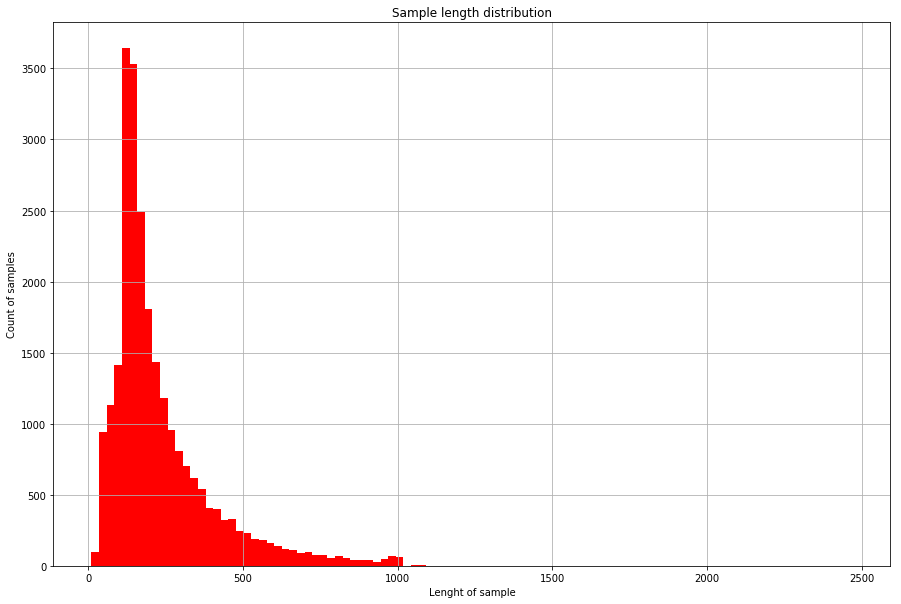

In [6]:
plot_sample_length_distribution(train_texts)

### Algorithm for Data Preparation and Model Building
1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a
simple multi-layer perceptron (MLP) model to classify them (left branch in the
flowchart below):
  a. Split the samples into word n-grams; convert the n-grams into vectors.
  b. Score the importance of the vectors and then select the top 20K using the scores.
  c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a
   sepCNN model to classify them (right branch in the flowchart below):
  a. Split the samples into words; select the top 20K words based on their frequency.
  b. Convert the samples into word sequence vectors.
  c. If the original number of samples/number of words per sample ratio is less
     than 15K, using a fine-tuned pre-trained embedding with the sepCNN
     model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.

Set *vectorization* parameters, limit *number* of features, choose *token mode*, *discard* corpus with frequency < 2

In [7]:
NGRAM_RANGE = (1, 2)
TOP_K = 20000
TOKEN_MODE = 'word' # another option is 'char'
MIN_DOC_FREQUENCY = 2

In [17]:
def vectorize_ngram(train_texts, train_labels, val_texts):
    kwargs = {
        'ngram_range': NGRAM_RANGE, # use unigrams & bigrams
        'dtype': 'int32',
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': TOKEN_MODE,
        'min_df': MIN_DOC_FREQUENCY
    }
    # Create vectorizer instance
    vectorizer = TfidfVectorizer(**kwargs)
    # Learn vocabulary from training set & vectorize training texts
    X_train = vectorizer.fit_transform(train_texts)
    # transform test set
    X_val = vectorizer.transform(val_texts)
    
    # Select top K vectorized features
    selector = SelectKBest(score_func=f_classif, k=min(TOP_K, X_train.shape[1]))
    selector.fit(X_train, train_labels)
    X_train = selector.transform(X_train).astype('float32')
    X_val = selector.transform(X_val).astype('float32')
    return X_train, X_val

In [11]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense, Dropout

In [32]:
def get_last_layer(num_classes):
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    op_units, op_activation = get_last_layer(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate))
    
    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))
    # Last layer
    model.add(Dense(units=op_units, activation=op_activation))
    
    return model


def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    (train_texts, train_labels, val_texts, val_labels) = data
    num_classes = get_num_classes(train_labels)
    
    unexpected_labels = [l for l in val_labels if l not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError(f'there are some unexpected labels in validation set such as {unexpected_labels}.')
    
    # Vectorize texts:
    X_train, X_val = vectorize_ngram(train_texts, train_labels, val_texts)
    
    # Create a multilayer perceptron
    model = mlp_model(layers=layers,
                      units=units,
                      dropout_rate=dropout_rate,
                      input_shape=X_train.shape[1:],
                      num_classes=num_classes)
    # Choose type of loss
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    # Pick an optimizer
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
    # Stop training if the loss is not converging
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
    
    history = model.fit(x=X_train,
                        y=train_labels,
                        epochs=epochs,
                        callbacks=callbacks,
                        validation_data=(X_val, val_labels),
                        verbose=2,  # Logs once per epoch.
                        batch_size=batch_size)

    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('IMDb_mlp_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]

In [33]:
train_ngram_model(data=load_imdb_sentiment_analysis_data())

/home/yurii/jupyter_envs/nlp/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1577: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


ValueError: Please provide as model inputs either a single array or a list of arrays. You passed: x=  (0, 112)	0.009362777
  (0, 253)	0.01695334
  (0, 382)	0.015232822
  (0, 537)	0.011793215
  (0, 680)	0.025807288
  (0, 708)	0.03491824
  (0, 752)	0.028357456
  (0, 769)	0.046636384
  (0, 958)	0.02702803
  (0, 964)	0.019627532
  (0, 972)	0.01821091
  (0, 1182)	0.03337962
  (0, 1215)	0.019942911
  (0, 1377)	0.0247151
  (0, 1402)	0.0376643
  (0, 1620)	0.01566047
  (0, 1647)	0.021632886
  (0, 1775)	0.0083106775
  (0, 2094)	0.02946515
  (0, 2132)	0.031468213
  (0, 2137)	0.026044557
  (0, 2259)	0.023916056
  (0, 2271)	0.019564958
  (0, 2281)	0.011643428
  (0, 2308)	0.035241667
  :	:
  (24999, 12125)	0.04255081
  (24999, 12777)	0.07368688
  (24999, 13663)	0.069687724
  (24999, 14262)	0.046546824
  (24999, 14265)	0.0627084
  (24999, 14437)	0.030904347
  (24999, 14472)	0.045807716
  (24999, 15214)	0.04087393
  (24999, 15591)	0.06357261
  (24999, 16119)	0.032770094
  (24999, 16141)	0.059285223
  (24999, 16152)	0.08767459
  (24999, 16180)	0.09161612
  (24999, 16244)	0.091852345
  (24999, 16510)	0.086049095
  (24999, 17213)	0.0159686
  (24999, 17553)	0.0154418275
  (24999, 17705)	0.03997247
  (24999, 17808)	0.03593197
  (24999, 17809)	0.07382394
  (24999, 18393)	0.041293267
  (24999, 18395)	0.07244558
  (24999, 18699)	0.020861581
  (24999, 18877)	0.05168561
  (24999, 19374)	0.034672137

In [51]:
X_train, y_train, X_test, y_test = load_imdb_sentiment_analysis_data()

In [52]:
X_train, X_test = vectorize_ngram(X_train, y_train, X_test)

/home/yurii/jupyter_envs/nlp/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1577: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)
